Estudio de regiones evanescentes al tener ondas en modo X

In [1]:
#librerías
import numpy as np
import matplotlib.pyplot as plt #gráficos
from scipy import interpolate #interpolación 1
from scipy.interpolate import griddata #interpolación 2
import h5py #archivos en hdf5
from jupyterlab_h5web import H5Web #librería
from pathlib import Path, PurePath #manejo de rutas y archivos
%run -i ./Funciones.py #funciones importante

#Graficación
#idioma = 'español'
idioma = 'ingles'

if idioma == 'español':
    #plt.prop_cycle(color=['0C5DA5', '00B945', 'FF9500', 'FF2C00', '845B97'])
    #axes.prop_cycle : cycler('color', ['0C5DA5', '00B945', 'FF9500', 'FF2C00', '845B97', '474747', '9e9e9e'])
    #Latex y coma como separador decimal
    plt.rcParams['text.usetex'] = True #latex
    #plt.rc('text', usetex=False)
    plt.rcParams['axes.formatter.use_locale'] = True #formato de eje para la coma
    #se incluye paquete matematico útil, se corrige el error con el espacio y el espacio entre los números
    plt.rc('text.latex', preamble=r'\usepackage{pifont} \usepackage{amsmath} \DeclareUnicodeCharacter{202F}{\,} \usepackage{ziffer} \usepackage{siunitx}') 
    plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
    })
    import locale #líbreria para el formato
    locale.setlocale(locale.LC_ALL, "es_CR.utf8")

if idioma == 'ingles' :
    plt.rc('text.latex', preamble=r'\usepackage{pifont} \usepackage{amsmath} \usepackage{siunitx}')
    plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
    })

import locale #líbreria para el formato
locale.setlocale(locale.LC_ALL, "es_CR.utf8")

'es_CR.utf8'

(98, 40, 48)


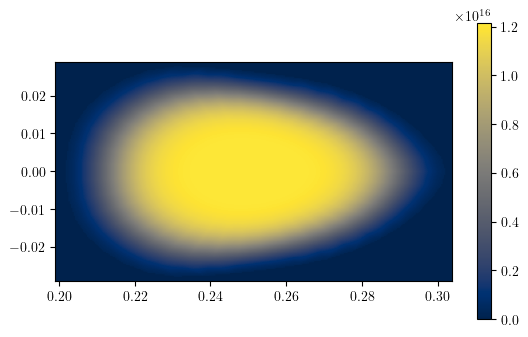

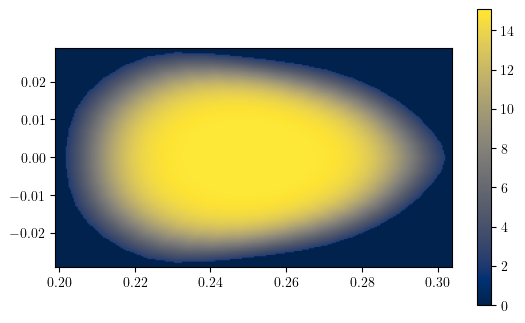

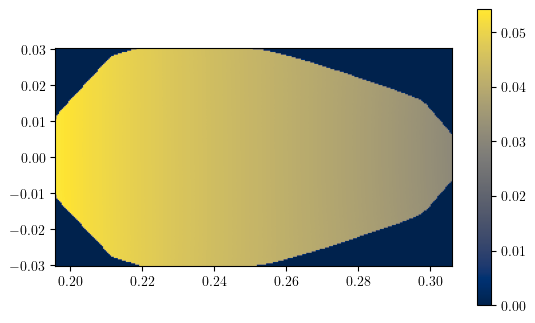

In [2]:
ruta_campo = 'ne_Te_r_z_B/r+z+B_mag_componentes.txt'
ruta_ne = 'ne_Te_r_z_B/densidad.txt'
ruta_Te = 'ne_Te_r_z_B/temperatura.txt'

n_e = np.loadtxt(ruta_ne)
T_e = np.loadtxt(ruta_Te)
r_BS, z_BS, B_x,B_y,B_z = np.loadtxt(ruta_campo, usecols=(0, 1, 2, 3, 4), unpack=True)

r_vmec, z_vmec = variables_vmec('input_VMEC', 'wout_scr_free.nc')
r,z = eliminar_eje_magnetico(r_vmec, z_vmec)
s2DB = campo_magnetico_mapa(r_BS, z_BS)
superficie_2D, ne1, Te1 = densidad_electronica_mapa(r,z,n_e, T_e)
ne_interpol = input_densidad(superficie_2D, ne1)
Te_interpol = input_densidad(superficie_2D, Te1)
B_xint, B_yint, B_zint = input_campo(s2DB, B_x, B_y, B_z)

6.140375029682791


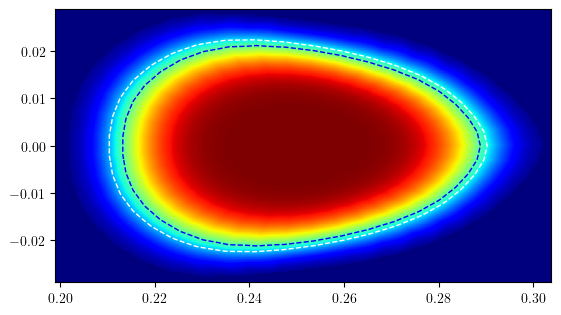

In [3]:
from scipy.constants import e, m_e, epsilon_0 #constantes físicas

#Constantes
f_calentamiento = 2.45e9
omega =  2*np.pi*f_calentamiento
n_corte = (m_e*epsilon_0*np.power(omega,2))/(np.power(e,2))

#Factor para un núcleo con un corte muy cerca del núcleo
factor_densidad1 = n_corte/np.max(ne_interpol)
print(factor_densidad1)
#factor_densidad = 6.1405*1.48
#factor_densidad = 6.1405*1.85
factor_densidad = 6.1405*2.14

#campo magnético neto
B_neto = np.sqrt( np.power(B_xint,2) + np.power(B_yint,2) + np.power(B_zint,2) ) 

#Malla
grid_r, grid_z = np.mgrid[0.19893:0.303797:297j, -0.0289025:0.0289019:165j] #cero grados - bsolctra solo 1000

#Frecuencia ciclotrónica electrónica
wce = ((e)/(m_e))*B_neto

#Frecuencia ciclotrónica electrónica normalizada
wec_norm = ((e)/(m_e*omega))*B_neto

#Factor de aumento en segundo armónico multiplicado y sumado
factor_B = 1
wec_norm_1 = ((e)/(m_e*omega))*(factor_B*B_neto)

#Frecuencia del plasma electrónica
wpe = ((factor_densidad*ne_interpol)*np.power(e,2))/(m_e*epsilon_0) #cuadrado de la frecuencia
wpe_norm = np.sqrt( ((factor_densidad*ne_interpol)*np.power(e,2))/(m_e*epsilon_0) )/omega

#Frecuencia híbrida superior normalizada --- Debe coincidir los valores de n_e y B interpolados
wuh_norm = (np.sqrt(np.power(wce,2) + wpe))/omega 

#Densidad electrónica normalizada
ne_norm = (factor_densidad*ne_interpol)/n_corte

#corte R
wR = 0.5 * (wce + np.sqrt((np.power(wce,2) + 4 * wpe)))
wR_norm = wR/omega

#corte L
wL = 0.5 * (-wce + np.sqrt((np.power(wce,2) + 4 * wpe)))
wL_norm = wL/omega

#Indice óptimo de refracción paralelo al campo
Y = wce/omega
N_par = np.sqrt(Y/(Y+1))
#print(np.max(N_par))


#Gráficos
levels = np.arange(1.0, 1.01, 1) #O mode cut-off
levels1 = np.arange(0.5,0.501, 0.5) # frecuencia de la onda incidente es la mitad de la frecuencia ciclotrónica electrónica
levels2 = np.linspace(0.53, 0.54, 2) #O mode cut-off
cmap= "jet"

#contour plots
dc = plt.imshow(np.flipud(ne_norm.T), extent=(0.19893,0.303797,-0.0289025,0.0289019), cmap = cmap) #density contour map for matplot lib for python
uh = plt.contour(grid_r,grid_z, wuh_norm, levels, linestyles = 'dashed', colors = 'white', linewidths = 1)
pe = plt.contour(grid_r,grid_z, wpe_norm, levels, linestyles = 'dashed', colors = 'blue', linewidths = 1)
#ce = plt.contour(grid_r,grid_z, wec_norm, levels1, linestyles = 'solid', colors = 'gray', linewidths =2)
#R = plt.contour(grid_r,grid_z,  wR_norm, levels, linestyles = 'solid', colors = 'orange', linewidths =1)
#L = plt.contour(grid_r,grid_z,  wL_norm, levels, linestyles = 'solid', colors = 'brown', linewidths =1)
#N = plt.contour(grid_r,grid_z,  N_par, levels2, linestyles = 'solid', colors = 'black', linewidths =1)
#plt.gca().clabel(N, inline=True, fontsize=10)

#ac = plt.colorbar(dc, orientation='vertical', shrink=0.8)
plt.gca().set_aspect("equal")
plt.show()

#for item1212 in uh.collections:
    #for i1 in item1212.get_paths():
        #v1 = i1.vertices
        #x1 = v1[:, 0]
        #y1 = v1[:, 1]
        #print(np.max(x1))

In [4]:
def posicion_uh_ne_con_ne(ne_interpol1, factor_densidad1, fact1, angulo, B_xint1, B_yint1, B_zint1):
    from scipy.constants import e, m_e, epsilon_0 #constantes físicas
    f_calentamiento1 = 2.45e9
    omega1 =  2*np.pi*f_calentamiento1
    #n_corte1 = (m_e*epsilon_0*np.power(omega1,2))/(np.power(e,2))
    
    #campo magnético neto
    B_neto1 = np.sqrt( np.power(B_xint1,2) + np.power(B_yint1,2) + np.power(B_zint1,2) ) 
    wpe1 = ((factor_densidad1*fact1*ne_interpol1)*np.power(e,2))/(m_e*epsilon_0) #cuadrado de la frecuencia
    wpe_norm1 = np.sqrt( ((factor_densidad1*fact1*ne_interpol1)*np.power(e,2))/(m_e*epsilon_0) )/omega1
    wce1 = ((e)/(m_e))*B_neto1
    wuh_norm1 = (np.sqrt(np.power(wce1,2) + wpe1))/omega1
    wL1 = 0.5 * (-wce1 + np.sqrt((np.power(wce1,2) + 4 * wpe1)))
    wL_norm1 = wL1/omega1
    #corte R
    wR1 = 0.5 * (wce1 + np.sqrt((np.power(wce1,2) + 4 * wpe1)))
    wR_norm1 = wR1/omega1
    
    grid_r, grid_z = np.mgrid[0.19893:0.303797:297j, -0.0289025:0.0289019:165j]
    levels = np.arange(1.0, 1.01, 1)
    #pe = plt.contour(grid_r,grid_z, wpe_norm1, levels, linestyles = 'dashed', colors = 'blue', linewidths = 1)
    uh = plt.contour(grid_r,grid_z, wuh_norm1, levels, linestyles = 'dashed', colors = 'red', linewidths = 1)
    L = plt.contour(grid_r,grid_z,  wL_norm1, levels, linestyles = 'solid', colors = 'black', linewidths =1)
    R = plt.contour(grid_r,grid_z,  wR_norm1, levels, linestyles = 'solid', colors = 'black', linewidths =1)
    plt.close() #no mostrar el gráfico
    
    for item in R.collections:
        for i1 in item.get_paths():
            v1 = i1.vertices
            x1 = v1[:, 0]
            y1 = v1[:, 1]
            #print(np.max(x1))
    
    for item1 in uh.collections:
        for i11 in item1.get_paths():
            v11 = i11.vertices
            x11 = v11[:, 0]
            y11 = v11[:, 1]
            #print(np.max(x11))
    
    for item11 in L.collections:
        for i111 in item11.get_paths():
            v111 = i111.vertices
            x111 = v111[:, 0]
            y111 = v111[:, 1]
            #print(np.max(x11))
    
    if angulo > 180 and angulo < 360 :
        angulo = angulo - 360       
    
    angulo_R = np.arctan2(-y1, (x1-0.247))
    angulo_uh = np.arctan2(-y11, (x11-0.247))
    angulo_L = np.arctan2(-y111, (x111-0.247))
    index_1 = find_nearest1(angulo_R, np.radians(angulo))
    index_2 = find_nearest1(angulo_uh, np.radians(angulo))
    index_3 = find_nearest1(angulo_L, np.radians(angulo))
    
    return x1[index_1], x11[index_2], x111[index_3], y1[index_1], y11[index_2], y111[index_3]
#factor_densidad = 6.1405
#posicion_uh_ne_con_ne(ne_interpol, factor_densidad, 2, 0.0, B_xint, B_yint, B_zint )

In [5]:
#Posición final de la UHR y corte en modo O dependiendo del factor de densidad
#Pensar mejor el valor del ángulo porque cambia con cada densidad
def plot_final_pos_uh_R(inf, sup, factor_ne, step) :
    from scipy.constants import c #constantes físicas
    aumento_factor_ne = np.arange(inf, sup, step)
    n_filas = aumento_factor_ne.shape[0]
    R_pos_t = np.ndarray((n_filas,), dtype=np.float64)
    uh_pos_t = np.ndarray((n_filas,), dtype=np.float64)
    L_pos_t = np.ndarray((n_filas,), dtype=np.float64)
    eta_ev = np.ndarray((n_filas,), dtype=np.float64)
    f_0 = 2.45e9
    for i in range(n_filas) : 
        fact_final = factor_ne*aumento_factor_ne[i]
        R_posx, uh_posx, L_posx, R_posy, uh_posy, L_posy = posicion_uh_ne_con_ne(ne_interpol, fact_final, aumento_factor_ne[i], 18, B_xint, B_yint, B_zint )
        R_pos_t[i] = np.sqrt(R_posx**2 + R_posy**2) 
        uh_pos_t[i] = np.sqrt(uh_posx**2 + uh_posy**2)
        L_pos_t[i] = np.sqrt(L_posx**2 + L_posy**2)
        coef = (2*np.pi*np.pi*(R_pos_t[i] - uh_pos_t[i])*f_0)/c
        eta_ev[i] = (1 - ( (1-np.exp(-coef))**2 + np.exp(-coef) )  )*100
        print((-uh_pos_t[i]+R_pos_t[i])*(2*np.pi*2.45e9)/(3e8))
    
    
    #Gráfico
    fig = plt.figure()  # create a figure object
    ax = fig.add_subplot(1, 1, 1)  # create an axes object in the figure   
    ax.plot(aumento_factor_ne, -uh_pos_t+R_pos_t , '--o', label=r'$\text{Distancia entre UHR y R}$', linewidth=2, color= '#00B945')
    #ax.plot(aumento_factor_ne, R_pos_t, '-', linewidth=2, color= '#0C5DA5', label = 'datos originales') #datos originales
    #ax.plot(aumento_factor_ne, uh_pos_t, '-', linewidth=2, color= '#00B945', label = 'datos originales') #datos originales
    #ax.plot(aumento_factor_ne, L_pos_t, '-', linewidth=2, color= '#845B97', label = 'datos originales') #datos originales
    ax.set_xlabel(r'$ n_{e}/n_{e\,corte} $ (1)', fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'black'})
    ax.set_ylabel( r'$ d $ (\si{\metre})', 
                  fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'black'})
    ax.tick_params(axis='both', labelsize=14, width=1.5) 
    plt.setp(ax.spines.values(), linewidth=1.5)
    
    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.plot(aumento_factor_ne, eta_ev, "--o", label=r'$\text{Absorción}$', color='#845B97')
    
    # ask matplotlib for the plotted objects and their labels
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper right', fontsize=11,  ncol=1, fancybox=True, shadow=True)
    ax2.set_ylabel( r'$ \eta_{x} $ (\si{\percent})', 
                  fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'black'})
    ax2.tick_params(axis='both', labelsize=14, width=1.5)
    #plt.savefig('dytau_xvsne.png', dpi=300, bbox_inches='tight') 
    plt.show()
plot_final_pos_uh_R(1.48, 2.14, 6.1405, 0.1 )

0.0871976724028387
0.09159354896613273
0.08439283087428368
0.0577984266319228
0.07339726110071357
0.06477874403459088
0.05568597423224094


In [5]:
#Excitation, Propagation, and Damping of Electron Bernstein Waves in Tokamaks
#Identificar ángulo donde está la absorción
def wce_Ln_LB_alfa_uh(ne_interpol1, factor_densidad1, fact1, factor_campo1, angulo, B_xint1, B_yint1, B_zint1 ):
    from scipy.constants import e, m_e, epsilon_0, c #constantes físicas
    f_calentamiento1 = 2.45e9
    omega1 =  2*np.pi*f_calentamiento1
    #campo magnético neto
    B_neto1 = factor_campo1*np.sqrt( np.power(B_xint1,2) + np.power(B_yint1,2) + np.power(B_zint1,2) )
    wpe1 =  ((factor_densidad1*fact1*ne_interpol1)*np.power(e,2))/(m_e*epsilon_0)  #cuadrado de la frecuencia
    wpe_norm1 = np.sqrt( ((factor_densidad1*fact1*ne_interpol1)*np.power(e,2))/(m_e*epsilon_0) )/omega1
    wce1 = ((e)/(m_e))*B_neto1
    wuh1 = (np.sqrt(np.power(wce1,2) + wpe1))
    wuh_norm1 = (np.sqrt(np.power(wce1,2) + wpe1))/omega1
    
    #L_n
    r = np.linspace(0.19893, 0.303797, 297)
    z = np.linspace(-0.0289025, 0.0289019, 165)
    delta_x = r[100]-r[99]
    delta_y = z[14]-z[13]
    grad_ne_x, grad_ne_y = np.gradient(ne_interpol1,delta_x, delta_y)
    grad_ne = np.sqrt(grad_ne_x**2 + grad_ne_y**2)
    L_n = np.abs( ne_interpol1 /(grad_ne) )
    print(np.max (  (ne_interpol1[126] -ne_interpol1[125]) / 7.45e16 *100 ) )
    
    #L_B
    grad_B_x, grad_B_y = np.gradient(B_neto1, delta_x, delta_y)
    grad_B = np.sqrt(grad_B_x**2 + grad_B_y**2)
    L_B = np.abs( B_neto1/(grad_B)) 
       
    
    #L_nabla = 0.5*np.arctan(tan_dos_alfa)
    # Supongamos que tienes una matriz L_nabla de tamaño nxm
    #n, m = L_nabla.shape

    # Aplica una condición para establecer valores fuera de la condición en NaN
    #condicion = L_nabla <= 0.1
    #L_nabla[~condicion] = np.nan

    # Restaura la forma original de la matriz
    #L_nabla = L_nabla.reshape((n, m))

    
    #a22 = plt.imshow(L_nabla.T)
    #a22 = plt.contourf(L_nabla)
    #plt.colorbar(a22)
    #plt.show()
    
    
    levels = np.arange(1.0, 1.01, 1) #O mode cut-off
    grid_r, grid_z = np.mgrid[0.19893:0.303797:297j, -0.0289025:0.0289019:165j] 
    pe = plt.contour(grid_r,grid_z, wpe_norm1, levels, linestyles = 'dashed', colors = 'blue', linewidths = 1)
    uh = plt.contour(grid_r,grid_z, wuh_norm1, levels, linestyles = 'dashed', colors = 'red', linewidths = 1)
    plt.close() #no mostrar el gráfico
    
    for item11 in uh.collections:
        for i11 in item11.get_paths():
            v11 = i11.vertices
            x11 = v11[:, 0]
            y11 = v11[:, 1]
            #print(np.max(x11))
    
    for item1 in pe.collections:
        for i1 in item1.get_paths():
            v1 = i1.vertices
            x1 = v1[:, 0]
            y1 = v1[:, 1]
            
            
    if angulo > 180 and angulo < 360 :
        angulo = angulo - 360       
    
    angulo_uh = np.arctan2(-y11, (x11-0.247))
    angulo_pe = np.arctan2(-y1, (x1-0.247))
    index = find_nearest1(angulo_uh, np.radians(angulo))
    index1 = find_nearest1(angulo_pe, np.radians(angulo))
    #print( x11[index], y11[index]) #se encuentran las coordendas espaciales
    #r = np.linspace(0.19893, 0.303797, 297)
    #z = np.linspace(-0.0289025, 0.0289019, 165)
    #indice_r = find_nearest1(r, x11[index]) #se buscan las coordenadas con las dimensiones
    #indice_z = find_nearest1(z, y11[index])
    indice_r = find_nearest1(r, x1[index1]) #se buscan las coordenadas con las dimensiones
    indice_z = find_nearest1(z, y1[index1])
    
    L_nabla_cm = 100*L_n[indice_r,indice_z]*np.power( ((2*np.pi*f_calentamiento1/3e8)*L_n[indice_r,indice_z]), -0.5)*np.power((wce1[indice_r,indice_z]/(2*omega1)), 0.25 )
    print("L_nabla es igual a ", L_nabla_cm, "cm")

    #cálculo de alfa (shalashov 2014)
    p_1 = L_n[indice_r,indice_z]/L_B[indice_r,indice_z]
    p_2 = 1+(wce1[indice_r,indice_z]/omega1)
    p_3 = np.abs(np.multiply(grad_ne[indice_r,indice_z], grad_B[indice_r,indice_z]))/(np.abs(grad_ne[indice_r,indice_z])*np.abs(grad_B[indice_r,indice_z]))
    tan_dos_alfa = p_1*np.power(p_2,-1)*p_3
    alfa = 0.5*np.arctan(tan_dos_alfa)
    print("El valor de alfa es", np.degrees(alfa), "grados")
    print("El ancho óptimo es", L_nabla_cm/(100*np.sqrt(np.sin(alfa))), "m")
    #a22 = plt.imshow(alfa.T)
    #plt.colorbar(a22)
    
    
    #variable para el parámetro de Budden
    alpha = np.sqrt( wpe1[indice_r,indice_z] )/wce1[indice_r,indice_z]
    wce_uhr = wce1[indice_r,indice_z]
    L_n_uhr = L_n[indice_r,indice_z]
    L_B_uhr = L_B[indice_r,indice_z]
    print(L_B_uhr)
    print(L_n_uhr)

    
    #Parámetro de budden
    frac_1 = (wce_uhr*L_n_uhr)/c
    frac_2 = L_n_uhr/L_B_uhr
    frac_3 = alpha/(np.sqrt(alpha**2 + 2*(frac_2) ))
    frac_4 = (np.sqrt(1+alpha**2)-1)/(alpha**2+(frac_2*(np.sqrt(1+alpha**2)) ) )
    eta = frac_1*frac_3*np.power(frac_4,0.5)
    
    #Transmitancia
    print('El parámetro de budden es', eta)
    print('La transmitancia de SX a FX es', np.exp(-np.pi*eta))
    lambda_01 = c/f_calentamiento1
    k_01 = (2*np.pi)/(lambda_01)
    #print(k_01*L_n[10:-20,82])
    #print(k_01*L_n_uhr)
    
    return eta, alpha
factor_densidad = 6.1405
wce_Ln_LB_alfa_uh(ne_interpol, factor_densidad, 2.14, 1.00, -178, B_xint, B_yint, B_zint )

0.04309961305503893
L_nabla es igual a  0.9331437066032201 cm
El valor de alfa es 0.7831162965972267 grados
El ancho óptimo es 0.07981848452466318 m
0.19148702166995626
0.008282899592711432
El parámetro de budden es 0.13876717012409595
La transmitancia de SX a FX es 0.6466501079256217


/tmp/ipykernel_127109/3039637042.py:22: RuntimeWarning: divide by zero encountered in true_divide
  L_n = np.abs( ne_interpol1 /(grad_ne) )
/tmp/ipykernel_127109/3039637042.py:22: RuntimeWarning: invalid value encountered in true_divide
  L_n = np.abs( ne_interpol1 /(grad_ne) )
/tmp/ipykernel_127109/3039637042.py:28: RuntimeWarning: invalid value encountered in true_divide
  L_B = np.abs( B_neto1/(grad_B))


(0.13876717012409595, 1.7402841496548793)

/tmp/ipykernel_94559/2209665418.py:21: RuntimeWarning: divide by zero encountered in true_divide
  L_n = np.abs( ne_interpol1 /(grad_ne) )
/tmp/ipykernel_94559/2209665418.py:21: RuntimeWarning: invalid value encountered in true_divide
  L_n = np.abs( ne_interpol1 /(grad_ne) )
/tmp/ipykernel_94559/2209665418.py:27: RuntimeWarning: invalid value encountered in true_divide
  L_B = np.abs( B_neto1/(grad_B))


L_nabla es igual a  0.747866184808612 cm
El ancho óptimo es 0.5715309877912487 m
121.05883804041034
[0.51111111]


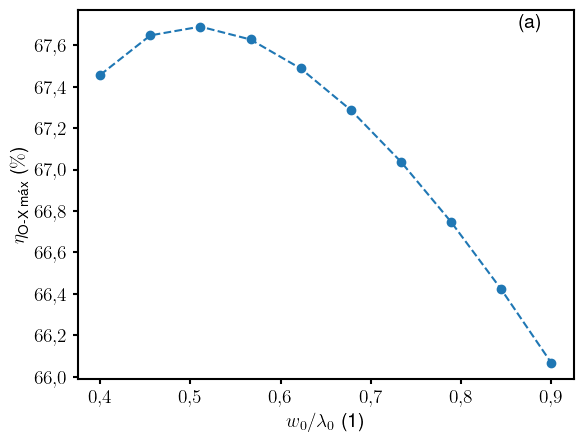

In [11]:
#Tramitancia shalashov 2018
def T(ne_interpol1, factor_densidad1, fact1, angulo, red, B_xint1, B_yint1, B_zint1 ):
    from scipy.constants import e, m_e, epsilon_0, c #constantes físicas
    f_calentamiento1 = 2.45e9
    omega1 =  2*np.pi*f_calentamiento1
    #campo magnético neto
    B_neto1 = np.sqrt( np.power(B_xint1,2) + np.power(B_yint1,2) + np.power(B_zint1,2) )
    wpe1 =  ((factor_densidad1*fact1*ne_interpol1)*np.power(e,2))/(m_e*epsilon_0)  #cuadrado de la frecuencia
    wpe_norm1 = np.sqrt( ((factor_densidad1*fact1*ne_interpol1)*np.power(e,2))/(m_e*epsilon_0) )/omega1
    wce1 = ((e)/(m_e))*B_neto1
    wuh1 = (np.sqrt(np.power(wce1,2) + wpe1))
    wuh_norm1 = (np.sqrt(np.power(wce1,2) + wpe1))/omega1
    
    #L_n
    r = np.linspace(0.19893, 0.303797, 297)
    z = np.linspace(-0.0289025, 0.0289019, 165)
    delta_x = r[100]-r[99]
    delta_y = z[14]-z[13]
    grad_ne_x, grad_ne_y = np.gradient(ne_interpol1,delta_x, delta_y)
    grad_ne = np.sqrt(grad_ne_x**2 + grad_ne_y**2)
    L_n = np.abs( ne_interpol1 /(grad_ne) )
    #print(np.max (  (ne_interpol1[126] -ne_interpol1[125]) / 7.45e16 *100 ) )
    
    #L_B
    grad_B_x, grad_B_y = np.gradient(B_neto1, delta_x, delta_y)
    grad_B = np.sqrt(grad_B_x**2 + grad_B_y**2)
    L_B = np.abs( B_neto1/(grad_B)) 
       
    
    levels = np.arange(1.0, 1.01, 1) #O mode cut-off
    grid_r, grid_z = np.mgrid[0.19893:0.303797:297j, -0.0289025:0.0289019:165j] 
    pe = plt.contour(grid_r,grid_z, wpe_norm1, levels, linestyles = 'dashed', colors = 'blue', linewidths = 1)
    uh = plt.contour(grid_r,grid_z, wuh_norm1, levels, linestyles = 'dashed', colors = 'red', linewidths = 1)
    plt.close() #no mostrar el gráfico
    
    for item11 in uh.collections:
        for i11 in item11.get_paths():
            v11 = i11.vertices
            x11 = v11[:, 0]
            y11 = v11[:, 1]
            #print(np.max(x11))
    
    for item1 in pe.collections:
        for i1 in item1.get_paths():
            v1 = i1.vertices
            x1 = v1[:, 0]
            y1 = v1[:, 1]
            
            
    if angulo > 180 and angulo < 360 :
        angulo = angulo - 360       
    
    angulo_uh = np.arctan2(-y11, (x11-0.247))
    angulo_pe = np.arctan2(-y1, (x1-0.247))
    index = find_nearest1(angulo_uh, np.radians(angulo))
    index1 = find_nearest1(angulo_pe, np.radians(angulo))
    indice_r = find_nearest1(r, x1[index1]) #se buscan las coordenadas con las dimensiones
    indice_z = find_nearest1(z, y1[index1])
    
    L_nabla_cm = 100*L_n[indice_r,indice_z]*np.power( ((2*np.pi*f_calentamiento1/3e8)*L_n[indice_r,indice_z]), -0.5)*np.power((wce1[indice_r,indice_z]/(2*omega1)), 0.25 )
    print("L_nabla es igual a ", L_nabla_cm, "cm")

    #cálculo de alfa (shalashov 2014)
    p_1 = L_n[indice_r,indice_z]/L_B[indice_r,indice_z]
    p_2 = 1+(wce1[indice_r,indice_z]/omega1)
    p_3 = np.abs(np.multiply(grad_ne[indice_r,indice_z], grad_B[indice_r,indice_z]))/(np.abs(grad_ne[indice_r,indice_z])*np.abs(grad_B[indice_r,indice_z]))
    tan_dos_alfa = p_1*np.power(p_2,-1)*p_3
    alfa = 0.5*np.arctan(tan_dos_alfa)
    #print("El valor de alfa es", np.degrees(alfa), "grados")
    print("El ancho óptimo es", L_nabla_cm/(100*np.sqrt(np.sin(alfa)))*f_calentamiento1/c, "m")
    
    
    an = np.linspace(0.4, 0.9, 10)*c/f_calentamiento1
    
    #Tramitancia para conversion ox predicha por shalashov2018, ecuacion 18
    #Numerador
    T_1 = 1 + np.tanh(np.pi*np.tan(alfa))
    #Denominador
    L_nabla_m = L_n[indice_r,indice_z]*np.power( ((2*np.pi*f_calentamiento1/3e8)*L_n[indice_r,indice_z]), -0.5)*np.power((wce1[indice_r,indice_z]/(2*omega1)), 0.25 )
    a_0 = L_nabla_m/(np.sqrt(np.sin(alfa)))
    kyy = 0.01*np.pi/(3.47e-2*L_nabla_m) #ec 25
    print(kyy)
    phi_c = 0
    lambda_y = 0.01
    delta_k = (4/(an*lambda_y)**2)*(1+phi_c)*( 1 + ((an/L_nabla_m)**2*np.sin(alfa)*np.tanh(np.pi*np.tan(alfa)) ))
    kyy_c = kyy**2 + delta_k  
    epsi = (an/a_0)**2 + (a_0/an)**2 + (kyy*a_0*an)**2
    epsi2 = (an/a_0)**2 + (a_0/an)**2 + kyy_c*(a_0*an)**2 #corregido
    T_2 = 1 + epsi*np.tanh( np.abs(np.pi*np.tan(alfa)) ) + (np.tanh(np.pi*np.tan(alfa)) )**2
    T_2_c = 1 + epsi2*np.tanh( np.abs(np.pi*np.tan(alfa)) ) + (np.tanh(np.pi*np.tan(alfa)) )**2
    T_final_c = T_1/np.sqrt(T_2_c)
    T_final = T_1/np.sqrt(T_2)
    
    T_promedio = (1 - red)*T_final_c + red*T_final
    T_final_max = np.max(T_promedio )
    
    print( an[np.where(T_promedio == T_final_max)] * f_calentamiento1/c)
    
    plt.plot(an*f_calentamiento1/c, T_promedio*100, "--o")
    plt.xlabel(r'$w_0/\lambda_0$ (1)', fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'black'})
    plt.ylabel( r'$ \eta_{\text{O-X máx}}$ (\si{\percent})', fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'black'})
    plt.tick_params(axis='both', labelsize=14, width=1.5)
    ax = plt.gca()
    ax.text(0.89, 0.95, '(a)', fontsize = 14, 
                             fontdict=None, color='black', transform=ax.transAxes ) #Etiquetar gráfica
    plt.setp(ax.spines.values(), linewidth=1.5)
    
factor_densidad = 6.1405
T(ne_interpol, factor_densidad, 2.14, 18, 0.5, B_xint, B_yint, B_zint )
plt.savefig('tau_vs_ancho_teoria.png', dpi=300, bbox_inches='tight')

In [9]:
def plot_sxfx(ne_inicial, factor_ne, inicio, final, Bx, By, Bz):
    aumento_factor_ne = np.linspace(inicio, final, 10) #matriz con densidades
    angulo = np.array([-13, 18, -105, -179 ])
    n_filas = aumento_factor_ne.shape[0] #numero de elementos
    n_angulo = angulo.shape[0]
    buddensxfx = np.ndarray((n_filas,), dtype=np.float64) #matriz para almacenar
    L_ne = np.ndarray((n_filas,), dtype=np.float64)
    sxfx_final = np.ndarray((n_angulo, n_filas), dtype = np.float64)
    
    for j in range(n_angulo):
        for i in range(n_filas) :
            eta_b, Lne = wce_Ln_LB_alfa_uh(ne_inicial, factor_ne, aumento_factor_ne[i], 1.00, angulo[j], Bx, By, Bz)
            buddensxfx[i] = eta_b
            L_ne[i] = Lne
        sxfx_final[j] = buddensxfx
        #plt.plot(aumento_factor_ne, np.exp(-np.pi*buddensxfx)*100, '--o', label=r'$1$', linewidth=2, color= '#0C5DA5')
        #print((2*np.pi*2.45e9/3e8))
        #print(L_ne[i])
    color=['#0C5DA5', '#00B945', '#FF9500', '#FF2C00']
    #label = [r'$\text{Región \ding{172}}$', r'$\text{Región \ding{173}}$', r'$\text{Región \ding{174}}$', r'$\text{Región \ding{175}}$']
    label = [r'$\text{Zone \ding{172}}$', r'$\text{Zone \ding{173}}$', r'$\text{Zone \ding{174}}$', r'$\text{Zone \ding{175}}$']
    for k in range(n_angulo) :
        exponencial = np.exp(-np.pi*sxfx_final[k])
        plt.plot(aumento_factor_ne, exponencial*100, '--o', linewidth=3, color= color[k], label = label[k])
    plt.legend(loc='lower right', fontsize=11,  ncol=1, fancybox=True, shadow=True)
    #plt.plot(aumento_factor_ne, np.exp(-np.pi*sxfx_final[0])*100, '--o', label=r'$1$', linewidth=2, color= '#0C5DA5')
    #plt.plot(aumento_factor_ne, np.exp(-np.pi*sxfx_final[1])*100, '--o', label=r'$1$', linewidth=2, color= '#0C5DA5')
    #plt.show()
    #fig = plt.figure()  # create a figure object
    #ax = fig.add_subplot(1, 1, 1)  # create an axes object in the figure   
    #plt.xlabel(r'$ n_{e}/n_{e\,corte} $ (1)', fontdict = {'fontsize':16, 'fontweight':'bold', 'color':'black'})
    plt.xlabel(r'$ n_{e}/n_{e\,cut} $ (1)', fontdict = {'fontsize':16, 'fontweight':'bold', 'color':'black'})
    plt.ylabel( r'$ \eta_{SX-FX} $ (\si{\percent})', 
                  fontdict = {'fontsize':16, 'fontweight':'bold', 'color':'black'})
    plt.tick_params(axis='both', labelsize=14, width=1.5) 
    ax = plt.gca()
    plt.setp(ax.spines.values(), linewidth=1.5)
    #print(buddensxfx)
    plt.ylim(45-0.1,85+0.1)
    #plt.savefig('tau_bvsne.png', dpi=300, bbox_inches='tight')
    plt.savefig('tau_bvsne.eps', format='eps', dpi=300, bbox_inches='tight') #paper IOP
    #plt.show()
plot_sxfx(ne_interpol, 6.1405, 1.48, 2.14, B_xint, B_yint, B_zint)
#plt.show()

/tmp/ipykernel_127109/3039637042.py:22: RuntimeWarning: divide by zero encountered in true_divide
  L_n = np.abs( ne_interpol1 /(grad_ne) )
/tmp/ipykernel_127109/3039637042.py:22: RuntimeWarning: invalid value encountered in true_divide
  L_n = np.abs( ne_interpol1 /(grad_ne) )
/tmp/ipykernel_127109/3039637042.py:28: RuntimeWarning: invalid value encountered in true_divide
  L_B = np.abs( B_neto1/(grad_B))


0.04309961305503893
L_nabla es igual a  1.0017803278583606 cm
El valor de alfa es 1.4450149260472234 grados
El ancho óptimo es 0.0630842100479334 m
0.15505544109491073
0.011160646974441095
El parámetro de budden es 0.125950355479483
La transmitancia de SX a FX es 0.6732189206691003
0.04309961305503893
L_nabla es igual a  0.9718733613890563 cm
El valor de alfa es 1.2968854324858559 grados
El ancho óptimo es 0.06460092420089593 m
0.16319666731698895
0.010527083166454185
El parámetro de budden es 0.11851865923410854
La transmitancia de SX a FX es 0.6891217286687495
0.04309961305503893
L_nabla es igual a  0.906757604663205 cm
El valor de alfa es 1.1178635723929904 grados
El ancho óptimo es 0.0649190113371139 m
0.16514463741030114
0.009174308142854175
El parámetro de budden es 0.10340514734522728
La transmitancia de SX a FX es 0.7226307899377581
0.04309961305503893
L_nabla es igual a  0.9035398406839338 cm
El valor de alfa es 1.1277522276372585 grados
El ancho óptimo es 0.06440443844308463 

L_nabla es igual a  0.6437805000254295 cm
El valor de alfa es 0.35109476022564634 grados
El ancho óptimo es 0.08224098798669269 m
0.2270750151855648
0.004206056303325717
El parámetro de budden es 0.061706545953377726
La transmitancia de SX a FX es 0.8237758346218644
0.04309961305503893
L_nabla es igual a  1.2304408475798676 cm
El valor de alfa es 1.3515567487805749 grados
El ancho óptimo es 0.08011706896577442 m
0.1961683936888748
0.014545611856704927
El parámetro de budden es 0.2335517946802976
La transmitancia de SX a FX es 0.480117409243297
0.04309961305503893
L_nabla es igual a  1.1537105644786525 cm
El valor de alfa es 1.1786546938688054 grados
El ancho óptimo es 0.08044150852271019 m
0.19717982614651988
0.01276482179524457
El parámetro de budden es 0.20730298993231286
La transmitancia de SX a FX es 0.5213876050324487
0.04309961305503893
L_nabla es igual a  1.1089653181264445 cm
El valor de alfa es 1.090860086918534 grados
El ancho óptimo es 0.0803725733181278 m
0.1962523537367231

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [9]:
#Mecanismo de amortiguamiento del segundo armónico
#Identificar ángulo donde está la absorción
def damping_2doarmonico(ne_interpol1, Te_interpol1, factor_densidad1, fact1, angulo, B_xint1, B_yint1, B_zint1 ):
    from scipy.constants import e, m_e, epsilon_0, c #constantes físicas
    f_calentamiento1 = 2.45e9
    omega1 =  2*np.pi*f_calentamiento1
    
    
    #campo magnético neto
    B_neto1 = np.sqrt( np.power(B_xint1,2) + np.power(B_yint1,2) + np.power(B_zint1,2) )
    wpe1 =  ((factor_densidad1*fact1*ne_interpol1)*np.power(e,2))/(m_e*epsilon_0)  #cuadrado de la frecuencia
    wpe_norm1 = np.sqrt( ((factor_densidad1*fact1*ne_interpol1)*np.power(e,2))/(m_e*epsilon_0) )/omega1
    wce1 = ((e)/(m_e))*B_neto1
    wce_norm1 =  ( ((e)/(m_e))*B_neto1 ) /omega1
    wuh1 = (np.sqrt(np.power(wce1,2) + wpe1))
    wuh_norm1 = (np.sqrt(np.power(wce1,2) + wpe1))/omega1
    
    #L_B
    r = np.linspace(0.19893, 0.303797, 297)
    z = np.linspace(-0.0289025, 0.0289019, 165)
    delta_x = r[100]-r[99]
    delta_y = z[14]-z[13]
    grad_B_x, grad_B_y = np.gradient(B_neto1, delta_x, delta_y)
    grad_B = np.sqrt(grad_B_x**2 + grad_B_y**2)
    L_B = np.abs( B_neto1/(grad_B)) 
    
    #Velocidad térmica
    v_th = np.sqrt((2*e*Te_interpol1)/(m_e))
    
    levels1 = np.arange(0.5,0.501, 0.5)
    levels = np.arange(1.0, 1.01, 1) #O mode cut-off
    grid_r, grid_z = np.mgrid[0.19893:0.303797:297j, -0.0289025:0.0289019:165j] 
    pe = plt.contour(grid_r,grid_z, wpe_norm1, levels, linestyles = 'dashed', colors = 'blue', linewidths = 1)
    ce = plt.contour(grid_r,grid_z, wce_norm1, levels1, linestyles = 'dashed', colors = 'red', linewidths = 1)
    plt.close() #no mostrar el gráfico
    
    for item1 in ce.collections:
        for i11 in item1.get_paths():
            v11 = i11.vertices
            x11 = v11[:, 0]
            y11 = v11[:, 1]
            #print(np.max(x11))
    
    #if angulo > 180 and angulo < 360 :
        #angulo = angulo - 360       
    
    angulo_pe = np.arctan2(-y11, (x11-0.247))
    index = find_nearest1(angulo_pe, np.radians(angulo))
    indice_r = find_nearest1(r, x11[index]) #se buscan las coordenadas con las dimensiones
    indice_z = find_nearest1(z, y11[index])
    
    #variable para el parámetro de Budden
    v_th_o = v_th[indice_r,indice_z]
    L_B_o = L_B[indice_r,indice_z]
    theta = -np.radians(170)
    #print(theta)
    lambda_0 = (2*np.pi*c)/wce1[indice_r,indice_z]
    print(v_th_o)
    
    #Optical depth - modo ordinario
    T1 = 2*np.pi*np.pi*np.sin(theta)*np.sin(theta)*(1+np.cos(theta)**2)
    T2 = wpe1[indice_r,indice_z]/np.power(wce1[indice_r,indice_z], 2)
    T3 = np.power( (v_th_o/c), 2) 
    T4 = L_B_o/lambda_0
    T5 = 0.5
    T6 =  (0.125*np.sin(theta)**4 + np.cos(theta)**2)/( (0.0625*np.sin(theta)**4+np.cos(theta)**2)**0.5 
                                                       * (1+np.cos(theta)**2) )  
    T7 = T5 - T6
    #T7 = 1 
    eta_o = T1*T2*T3*T4*T7
    print(T1, T2, T3, T4, T5, T6)
    print(np.sqrt(wpe1[indice_r,indice_z])/1e10, 2*wce1[indice_r,indice_z]/1e10)
    #Transmitancia
    print('El optical depth del modo ordinario es', eta_o)
    #print('La transmitancia de SX a FX es', np.exp(np.pi*eta_o))
    
    #return eta, alpha
damping_2doarmonico(ne_interpol, Te_interpol, 6.1405, 2.14, 0, B_xint, B_yint, B_zint )

2301665.8432149976
1.1724721737726238 8.578122867346199 5.894447986679051e-05 0.9334385717555629 0.5 0.4999853554117925
2.2519423004955668 1.5377690761931218
El optical depth del modo ordinario es 8.104026525470856e-09


/tmp/ipykernel_23021/2025134028.py:25: RuntimeWarning: invalid value encountered in true_divide
  L_B = np.abs( B_neto1/(grad_B))
